# Anomaly detection with embeddings

<table align="left">
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemini-api-cookbook/blob/main/examples/Anomaly_detection_with_embeddings.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Overview

This tutorial demonstrates how to use the embeddings from the Gemini API to detect potential outliers in your dataset. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and detect outliers outside a particular radius of the central point of each categorical cluster.


In [ ]:
!pip install -U -q google.generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 1.4 MB/s eta 0:00:00


In [ ]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import google.generativeai as genai
import google.ai.generativelanguage as glm

# Used to securely store your API key
from google.colab import userdata

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [ ]:
API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=API_KEY)

## Prepare dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. This tutorial uses the training subset.

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [ ]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [ ]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

# Cut off each text entry after 5,000 characters
newsgroups_train.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data]

In [ ]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, sample some of the data by taking 150 data points in the training dataset and choosing a few categories. This tutorial uses the science categories.

In [ ]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

,index,Text,Label,Class Name
0,1650,"Re: Once tapped, your code is no good any mor...",11,sci.crypt
1,1651,Re: The Old Key Registration Idea...\nOrganiz...,11,sci.crypt
2,1652,Re: text of White House announcement and Q&As...,11,sci.crypt
3,1653,"Re: Facinating facts: 30 bit serial number, p...",11,sci.crypt
4,1654,Re: Clipper considered harmful\nSummary: Buck...,11,sci.crypt
...,...,...,...,...
595,2245,Re: How to read sci.space without netnews\nOr...,14,sci.space
596,2246,Re: Sunrise/ sunset times\nOrganization: U of...,14,sci.space
597,2247,"Re: Moonbase race, NASA resources, why?\nOrga...",14,sci.space
598,2248,El Sets\nOrganization: MIT Lincoln Laboratory...,14,sci.space


In [ ]:
df_train['Class Name'].value_counts()

sci.crypt          150
sci.electronics    150
sci.med            150
sci.space          150
Name: Class Name, dtype: int64

## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

### API changes to Embeddings with model embedding-001

For the new embeddings model, embedding-001, there is a new task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")['embedding']
    return np.array(embedding)

  return embed_fn

def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(df_train)
df_train.drop('index', axis=1, inplace=True)

  0%|          | 0/600 [00:00<?, ?it/s]

## Dimensionality reduction

The dimension of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [ ]:
len(df_train['Embeddings'][0])

768

In [ ]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 768)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [ ]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

In [ ]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,28.129379,-11.789248,sci.crypt
1,26.299564,-4.172129,sci.crypt
2,34.118439,-17.731606,sci.crypt
3,38.964771,0.526057,sci.crypt
4,41.245209,-12.786042,sci.crypt
...,...,...,...
595,0.323349,-4.393069,sci.space
596,-16.115713,7.523082,sci.space
597,-10.407278,-17.786392,sci.space
598,-0.080828,-2.068839,sci.space


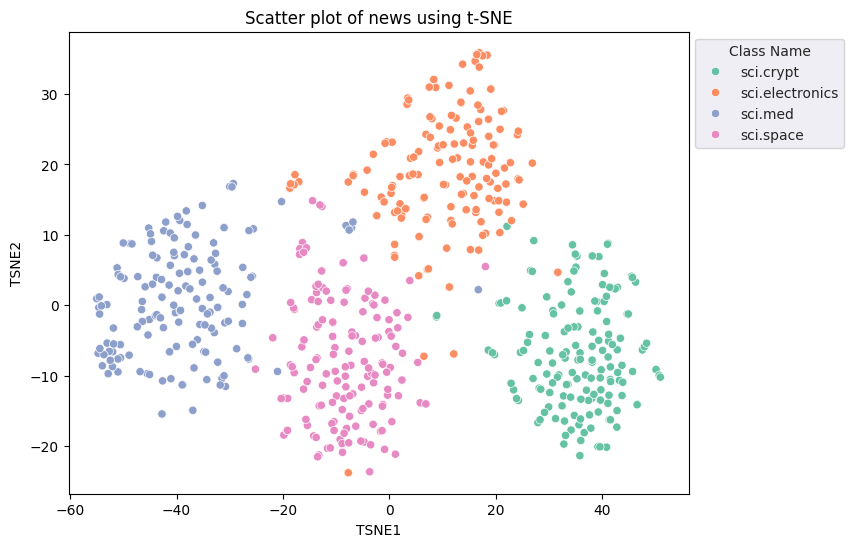

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

## Outlier detection

To determine which points are anomalous, you will determine which points are inliers and outliers. Start by finding the centroid, or location that represents the center of the cluster, and use the distance to determine the points that are outliers.

Start by getting the centroid of each category.

In [ ]:
def get_centroids(df_tsne):
  # Get the centroid of each cluster
  centroids = df_tsne.groupby('Class Name').mean()
  return centroids

centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
sci.crypt,35.479424,-7.063431
sci.electronics,10.636385,18.538465
sci.med,-38.865154,0.424798
sci.space,-8.314754,-7.814443


In [ ]:
def get_embedding_centroids(df):
  emb_centroids = dict()
  grouped = df.groupby('Class Name')
  for c in grouped.groups:
    sub_df = grouped.get_group(c)
    # Get the centroid value of dimension 768
    emb_centroids[c] = np.mean(sub_df['Embeddings'], axis=0)

  return emb_centroids

In [ ]:
emb_c = get_embedding_centroids(df_train)

Plot each centroid you have found against the rest of the points.

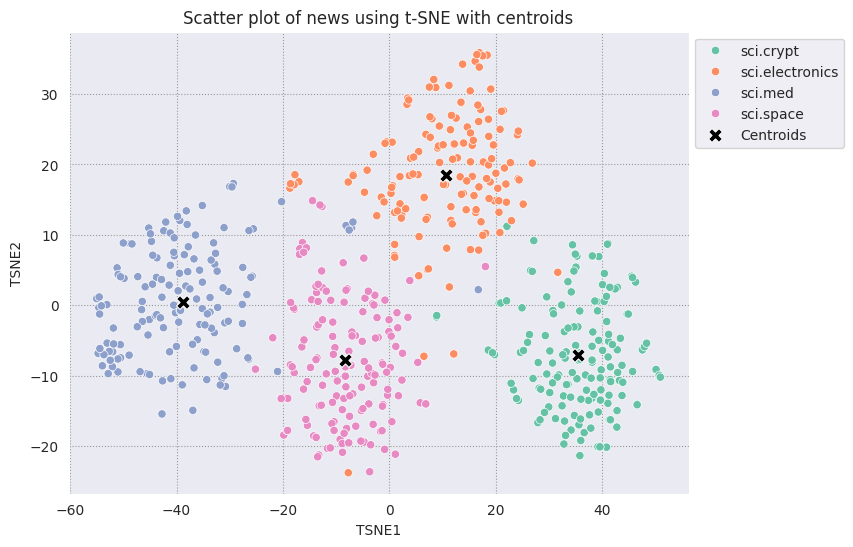

In [ ]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Choose a radius. Anything beyond this bound from the centroid of that category is considered an outlier.

In [ ]:
def calculate_euclidean_distance(p1, p2):
  return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
  for idx, row in df.iterrows():
    class_name = row['Class Name'] # Get class name of row
    # Compare centroid distances
    dist = calculate_euclidean_distance(row['Embeddings'],
                                        emb_centroids[class_name])
    df.at[idx, 'Outlier'] = dist > radius

  return len(df[df['Outlier'] == True])

In [ ]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
  num_outliers.append(detect_outlier(df_train, emb_c, i))

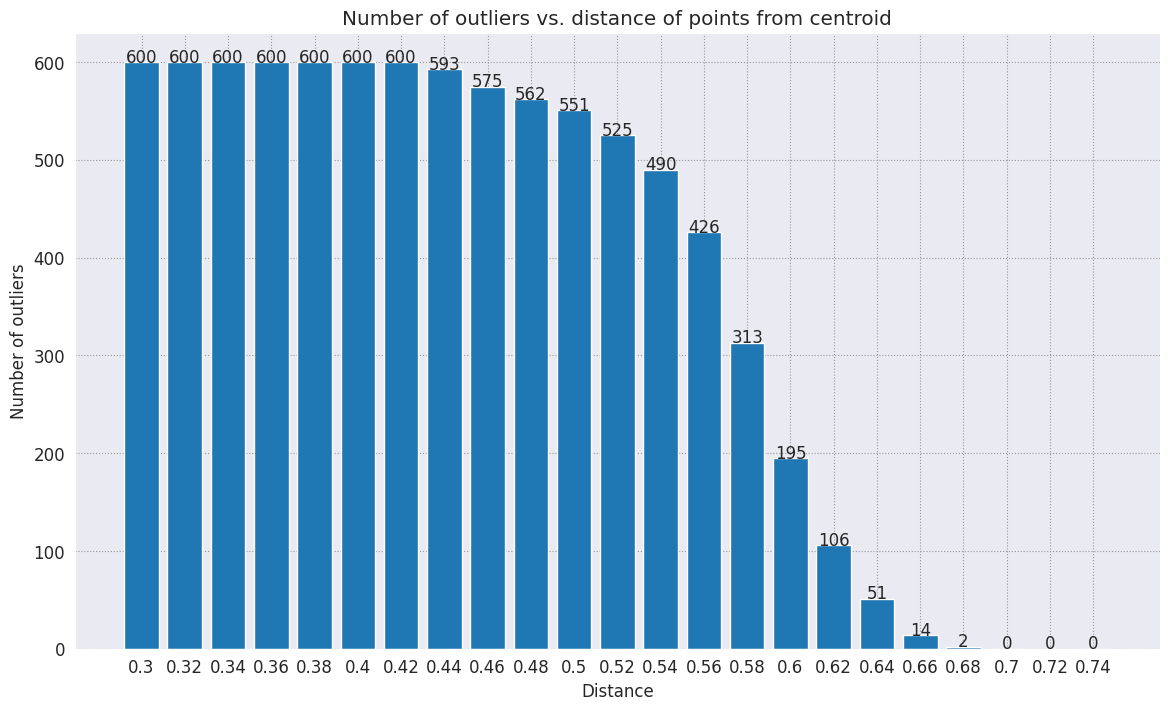

In [ ]:
# Plot range_ and num_outliers
fig = plt.figure(figsize = (14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
  plt.text(i, num_outliers[i], num_outliers[i], ha = 'center')

plt.show()

Depending on how sensitive you want your anomaly detector to be, you can choose which radius you would like to use. For now, 0.62 is used, but you can change this value.

In [ ]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train['Outlier'] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
11,Re: List of large integer arithmetic packages...,11,sci.crypt,"[-0.0055461614, 0.0061755483, -0.060710818, -0...",True
13,Marc VanHeyningen <>RIPEM Frequently Asked Que...,11,sci.crypt,"[0.016936606, -0.03775989, -0.031252615, -0.02...",True
14,"Re: Once tapped, your code is no good any mor...",11,sci.crypt,"[0.0175999, -0.04498857, 0.028067622, -0.04195...",True
30,Re: The source of that announcement\nOrganiza...,11,sci.crypt,"[0.0148236565, -0.023995584, -0.05186253, -0.0...",True
33,ISSA '93 Conference\nOrganization: Chinet - P...,11,sci.crypt,"[0.04542695, -0.0045831418, -0.026651457, -0.0...",True


In [ ]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers['Outlier'].index]

Plot the outliers and denote them using a transparent red color.

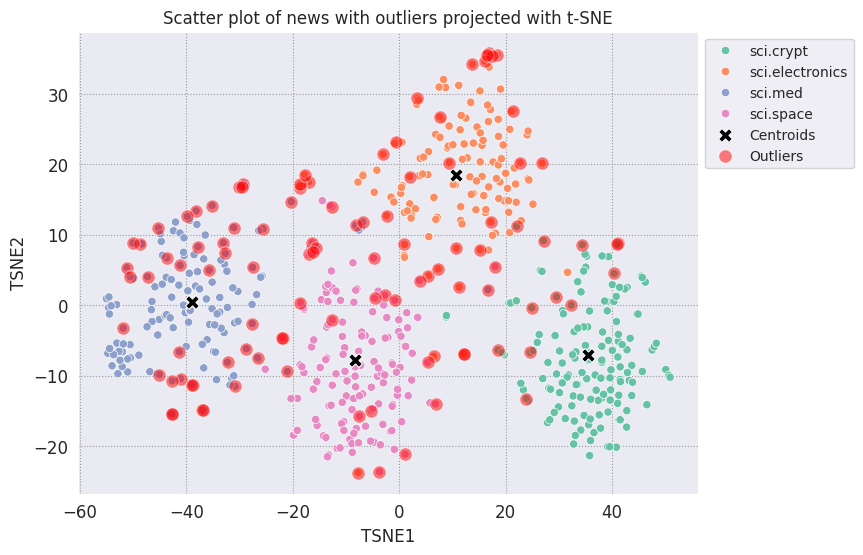

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# Draw a red circle around the outliers
sns.scatterplot(data=outliers_projected, x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Use the index values of the datafames to print a few examples of what outliers can look like in each category. Here, the first data point from each category is printed out. Explore other points in each category to see data that are deemed as outliers, or anomalies.

In [ ]:
sci_crypt_outliers = df_outliers[df_outliers['Class Name'] == 'sci.crypt']
print(sci_crypt_outliers['Text'].iloc[0])

 Re: List of large integer arithmetic packages
In-Reply-To: 's message of 20 Apr 1993 16: 47:03 GMT
Organization: York U. Student Information Systems Project
Lines: 18

Mark Riordan writes:

	[a list of large-integer arithmetic packages elided]

I thought I would note that except Lenstra's packages, none of the
large-integer packages are in the public domain. As an alternative,
a straightforward *PD* implementation of Knuth's algorithms may be
found as a part of Uof Arizona's ICON distribution.

oz
---
With diligence, it is possible to make | electric: 
anything run slowly.        --Tom Duff | ph:[416] 736 2100 x 33976

			






In [ ]:
sci_elec_outliers = df_outliers[df_outliers['Class Name'] == 'sci.electronics']
print(sci_elec_outliers['Text'].iloc[0])

 How starters work really
Keywords: fluorescent bulb starter neon
Nntp-Posting-Host: turbo_f.seas.smu.edu
Organization: SMU - School of Engineering & Applied Science - Dallas
Lines: 28

In article <>   writes:
>
>So when you turn on the power, this causes the bulb to work like a neon, 
>heating up and shorting out, thus providing a loop to power the heaters in 
>the main tube. When the tube fires, insufficient current runs through the 
>starter to keep the heat up and the bi-metalic strip straightens out 
>.

Imprecise. This description

 1. ignores the role of the ballast,
 2. misrepresents the heating effects in the starter.

The bimetalic strip cools down immediately after the contacts
short circuit, because the neon discharge stops, and much less
heat is generated from the I^2R loss in the metal as compared to
the neon discharge.

The starter contacts open before the tube fires.  Actually,
the tube fires as a result of the back-emf generated in the ballast
because of this immediate

In [ ]:
sci_med_outliers = df_outliers[df_outliers['Class Name'] == 'sci.med']
print(sci_med_outliers['Text'].iloc[0])

kxgst1+@pitt.edu Re: Do we need a Radiologist to read an Ultrasound?
Organization: University of Pittsburgh
Lines: 31

In article <>  writes:
:My wife's ob-gyn has an ultrasound machine in her office.  When
:the doctor couldn't hear a fetal heartbeat  she used
:the ultrasound to see if everything was ok.  
:
:On her next visit, my wife asked another doctor in the office if
:they read the ultrasounds themselves or if they had a radiologist
:read the pictures.  The doctor very vehemently insisted that they
:were qualified to read the ultrasound and radiologists were NOT!
:
:[stuff deleted]

This is one of those sticky areas of medicine where battles frequently
rage.  With respect to your OB, I suspect that she has been certified in
ultrasound diagnostics, and is thus allowed to use it and bill for its
use.  Many cardiologists also use ultrasound , and are
in fact considered by many to be the 'experts'.  I am not sure where OBs
stand in this regard, but I suspect that they are at least as

In [ ]:
sci_space_outliers = df_outliers[df_outliers['Class Name'] == 'sci.space']
print(sci_space_outliers['Text'].iloc[0])

 Astro/Space Frequently Seen Acronyms
Supersedes: <space/>
Organization: LifeForms Unlimited, Cephalopods
Lines: 509
Expires: 19 May 1993 04:00:04 GMT
NNTP-Posting-Host: pad-thai.aktis.com
Keywords: long space astro tla acronyms
X-Last-Updated: 1992/12/07

Archive-name: space/acronyms
Edition: 8

Acronym List for sci.astro, sci.space, and sci.space.shuttle:
Edition 8, 1992 Dec 7
Last posted: 1992 Aug 27

This list is offered as a reference for translating commonly appearing
acronyms in the space-related newsgroups.  If I forgot or botched your
favorite acronym, please let me know!  Also, if there's an acronym *not*
on this list that confuses you, drop me a line, and if I can figure
it out, I'll add it to the list.

Note that this is intended to be a reference for *frequently seen*
acronyms, and is most emphatically *not* encyclopedic.  If I incorporated
every acronym I ever saw, I'd soon run out of disk space!  :-)

The list will be posted at regular intervals, every 30 days.  All
comm

## Next steps

You've now created an anomaly detector using embeddings! Try using your own textual data to visualize them as embeddings, and choose some bound such that you can detect outliers. You can perform dimensionality reduction in order to complete the visualization step. Note that t-SNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).